# Finding Points on the Decision Boundary using KNN

A decision boundary is a plane that separates the data points belonging to different classes.

Every machine learning classification model seperates classes based on a decision boundary which it deduces.

In this notebook, we'll find points which are closest to the decision boundary using KNN.

Let's start off by importing the appropriate libraries.

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.datasets import make_blobs
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt

## Creating the Clusters

Use the make_blobs function to create two arrays X and y. 

The X array contains 1000 samples with 2 features each, while the y array contains the integer labels for cluster membership of each sample.

We created 2 clusters, each having a standard deviation of 3.

In [2]:
X, y = make_blobs(n_samples=1000, centers=2, n_features=2, random_state=26, cluster_std=3)

We create our dataset using the X and y variables.

In [3]:
df = pd.DataFrame(
        data = np.hstack([X, y.reshape(-1,1)]),
        columns = ['x1', 'x2', 'class']
     )

And we plot it.

We see that the clusters have some overlap, but in general, they're pretty seperable given our features x1 and x2.

<AxesSubplot:xlabel='x1', ylabel='x2'>

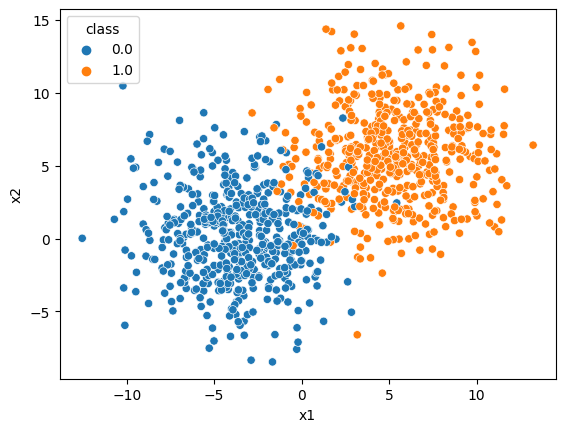

In [4]:
sns.scatterplot(x='x1', y='x2', hue='class', data=df)

We're going to create a very simple randomforest model.

We'll keep the max_depth at 2 so that it generalizes better.

In [5]:
model = RandomForestClassifier(max_depth=2, random_state=123)

Let's fit it.

In [6]:
model.fit(df.drop('class', axis=1), df['class'])

RandomForestClassifier(max_depth=2, random_state=123)

## Brute Force Decision Boundary Visualization

We're going to call this the brute force method to see the decision boundary.

It's a very simple approach. We create a grid of points and we predict for every point.

We'll use mesgrid to create our grid of x1 and x2 values.

We'll pass in 2 arrays, 1 for each feature. The arrays each have values from their minimum to their maximum values.

In [7]:
x1_mesh, x2_mesh =  np.meshgrid(
                        np.linspace(df['x1'].min(), df['x1'].max()),
                        np.linspace(df['x2'].min(), df['x2'].max())
                    )

Let's stack the values for the outputs of the meshgrid, so that it becomes a matrix.

In [8]:
boundary_data = np.hstack([x1_mesh.reshape(-1,1), x2_mesh.reshape(-1,1)])

And we'll create a dataframe with the features and the predicted class.

In [9]:
boundary_df = pd.DataFrame(
                data = np.hstack([boundary_data, 
                                  model.predict(
                                      pd.DataFrame(boundary_data, columns=['x1', 'x2'])
                                  ).reshape(-1,1)]),
                columns = ['x1', 'x2', 'class']
             )

Plotting the dataframe will give us a visualization of the decision boundary.

<AxesSubplot:xlabel='x1', ylabel='x2'>

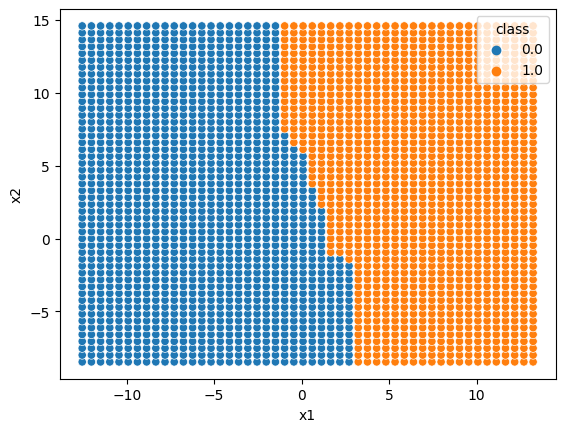

In [10]:
sns.scatterplot(x='x1', y='x2', hue='class', data=boundary_df)

## Finding the Decision Boundary Slither Using KNN

Now that we have a grid of points and we've visualized the decision boundary. What if we only want the points on/near the boundary? Something I call the boundary slither.

We can use KNN to find those points.

The idea is simple. If we train a KNN algorithm on the opposite class, we can then predict on the input class. The points which have the shortest distance are the points which are closest to the decision boundary.

Let's look at it in code.

We'll first import SKlearn's KNN class.

Thereafter, we'll create 3 functions.

**train_knn_opp_class:** Trains a KNN model on the opposite class of the input class. 

**find_opp_class_neigh:** Find the nearest neighbors of the input class in the opposite class using the KNN model trained by train_knn_opp_class

**find_boundary_slither:** Find the decision boundary between two classes by comparing the distances of each point in one class to its nearest neighbor in the opposite class and returning only those points that are below a certain threshold.

In [11]:
from sklearn.neighbors import KNeighborsClassifier

def train_knn_opp_class(df, opp_class, target_column):
    opp_class_df = df[df[target_column]==opp_class].reset_index(drop=True)
    
    model = KNeighborsClassifier(n_neighbors=1)
    model.fit(opp_class_df.drop(target_column, axis=1), opp_class_df[target_column])
    
    return model

def find_opp_class_neigh(df, input_class, opp_class, target_column='class'):
    input_class_df = df[df[target_column]==input_class].reset_index(drop=True)
    
    model = train_knn_opp_class(df, opp_class, target_column)
    neigh_distance, _ = model.kneighbors(input_class_df.drop(target_column, axis=1))
    
    return input_class_df.assign(neigh_distance=neigh_distance)

def find_boundary_slither(df_class0, df_class1, thresholds=[1,1]):
    return  pd.concat([
                df_class0[df_class0['neigh_distance']<thresholds[0]],
                df_class1[df_class1['neigh_distance']<thresholds[1]]
            ])

Using the functions we created, let's create 2 dataframes - 1 for each class.

We'll also create the boundary slither dataframe which will give us all the points which fall below our threshold distances.

In [12]:
df_class0 = find_opp_class_neigh(boundary_df, input_class=0, opp_class=1)
df_class1 = find_opp_class_neigh(boundary_df, input_class=1, opp_class=0)
boundary_slither_df = find_boundary_slither(df_class0, df_class1, thresholds=[1,1])

Let's plot the decision boundary slither along with the 2 clusters that we created at the start of this notebook.

Plotting the clusters helps us see how how our decision boundary lines up.

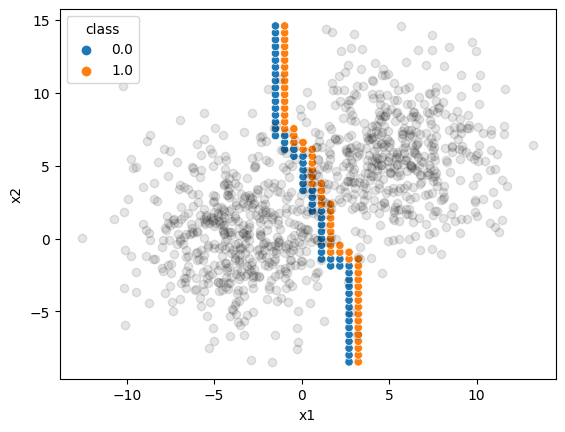

In [13]:
sns.scatterplot(x='x1', y='x2', hue='class', data=boundary_slither_df)
plt.plot(df['x1'], df['x2'], marker='o', color='black', linestyle='none', alpha=0.1)

## Finding the Points cloests to the Decision Boundary

The real value in this KNN method comes when we try to find which points from our original dataset are closest to the decision boundary.

We'll use the same method from above to do so with our original 2 clusters.

Let's first create our dataframe with the predicted values given by our randomforest model.

In [14]:
predicted_df =  pd.DataFrame(
                    data = np.hstack([df.drop('class', axis=1), 
                                      model.predict(df.drop('class', axis=1)).reshape(-1,1)
                                     ]),
                    columns = ['x1', 'x2', 'class']
                 )

Next, we'll create the 2 dataframes (1 for each class) using the KNN method.

In [15]:
df_class0 = find_opp_class_neigh(predicted_df, input_class=0, opp_class=1)
df_class1 = find_opp_class_neigh(predicted_df, input_class=1, opp_class=0)

Because the distances may vary, we'll plot our distances and choose thresholds using the lower values we see in our histograms.

<AxesSubplot:>

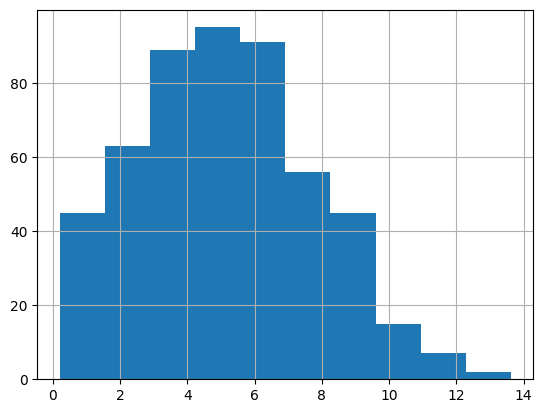

In [16]:
df_class0['neigh_distance'].hist()

<AxesSubplot:>

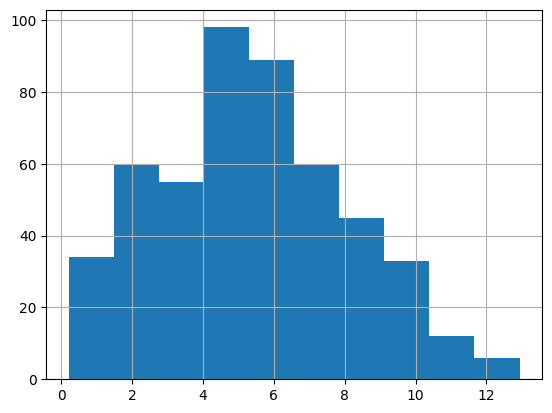

In [17]:
df_class1['neigh_distance'].hist()

Setting the thresholds to 2 it'll be large enough to include enough points, but small enough to still be considered close to the decision boundary.

In [18]:
boundary_slither_df = find_boundary_slither(df_class0, df_class1, thresholds=[2,2])

If we plot our decision boundary slither using the original dataset, we'll see we've done a good job at finding the points closes to the decision boundary

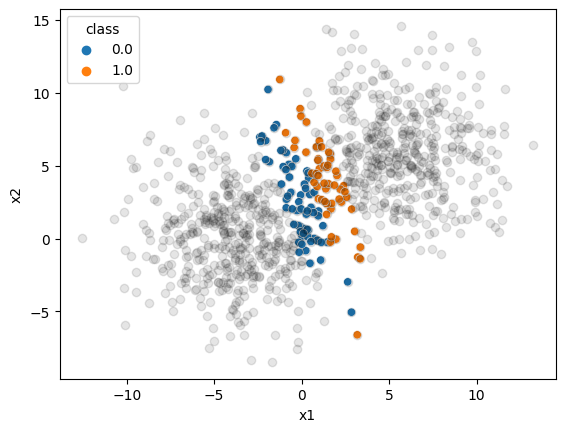

In [19]:
sns.scatterplot(x='x1', y='x2', hue='class', data=boundary_slither_df)
plt.plot(df['x1'], df['x2'], marker='o', color='black', linestyle='none', alpha=0.1)